Package beolvasás

In [17]:
import datetime
import math
from ntpath import join
import numbers
import os
import random
import sys
import warnings
from cgitb import scanvars
from re import A
from tkinter import font
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsa
import yfinance as yf
from arch import arch_model
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from pandas_datareader import test
from scipy import stats
from scipy.stats import moment, norm, probplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, q_stat
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
os.system("cls")

0

Alap Függvények

In [29]:
def hurst(ts):
 """Returns the Hurst Exponent of the time series vector ts"""
 # Create the range of lag values
 lags = range(2, 100)

 # Calculate the array of the variances of the lagged differences
 tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

 # Use a linear fit to estimate the Hurst Exponent
 poly = polyfit(log(lags), log(tau), 1)

 # Return the Hurst exponent from the polyfit output
 return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):
	lags = min(10, int(len(x)/5)) if lags is None else lags
	fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
	x.plot(ax=axes[0][0])
	q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
	stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
	axes[0][0].text(x=.05, y=.75, s=stats, transform=axes[0][0].transAxes)
	probplot(x, plot=axes[0][1])
	mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
	s = f'Átlag: {mean:>12.2f}\nSzórás: {np.sqrt(var):>16.2f}\nFerdeség: {skew:12.2f}\nCsúcsosság:{kurtosis:9.2f}'
	axes[0][1].text(x=.05, y=.70, s=s, transform=axes[0][1].transAxes)
	plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
	plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
	axes[1][0].set_xlabel('Lag', fontsize=11)
	axes[1][1].set_xlabel('Lag', fontsize=11)
	axes[0][0].set_xlabel('Dátum', fontsize=11)
	axes[0][0].tick_params(axis='x', labelrotation=0, pad=8)
	axes[0][1].set_xlabel('Elméleti kvantilisek', fontsize=11)
	axes[0][1].set_ylabel('Rendezett értékek', fontsize=11)
	axes[0][1].set_title("QQ-gráf", fontsize=15)
	axes[1][0].set_title("Autokorreláció", fontsize=15)
	axes[1][1].set_title("Parciális Autokorreláció", fontsize=15)
	fig.suptitle(title, fontsize=30, fontweight="bold")
	fig.tight_layout()
	fig.subplots_adjust(top=.9)
	fig.savefig(f"{name_of_the_financial_instrument}_korrelogram.svg")

def evaluate(observation, forecast):
 # Call sklearn function to calculate MAE
 mae = mean_absolute_error(observation, forecast)
 print(f'Mean Absolute Error (MAE): {round(mae,3)}')
 # Call sklearn function to calculate MSE
 mse = mean_squared_error(observation, forecast)
 print(f'Mean Squared Error (MSE): {round(mse,3)}')
 # Call sklearn function to calculate RMSE
 rmse= mean_squared_error(observation, forecast)
 print(f'Root Mean Squared Error (RMSE): {round(rmse,3)}')
 return mae, mse, rmse

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a= dataset[i:(i+time_step),0]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return np.array(dataX), np.array(dataY)

Adatbeolvasás, alap számolások

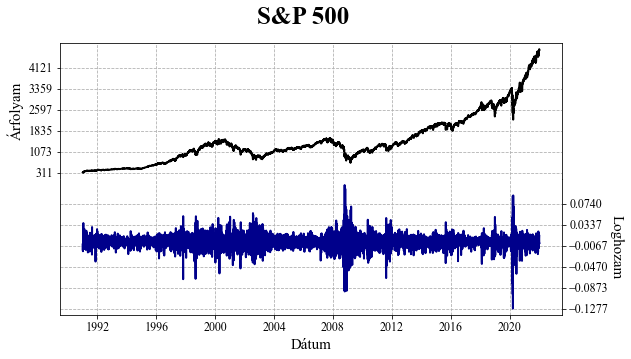

10
Évesített várható érték 0.06
Évesített szórás 0.19
Alapvető leíró statisztika:  count    5064.000000
mean        0.000166
std         0.011872
min        -0.094695
25%        -0.004682
50%         0.000552
75%         0.005670
max         0.109572
Name: Log_return, dtype: float64


In [23]:

name_of_the_financial_instrument="S&P 500"
##OPCIÓK: snp500, dxy, bloomberg_bond, djia, spgsci, stoxx, wgbi_monthly
load_csv='snp500' 
df=pd.read_csv(f"data\{load_csv}.csv")
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df=df[['Close']]
##Ábra az egész idősorról
plt.rc('font', family='Times New Roman')
fig = plt.figure(figsize=(9,5))
temp_abra=np.log(df['Close']/df['Close'].shift(1))
temp_abra=temp_abra.dropna()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle(f'{name_of_the_financial_instrument}', size=25, fontweight='bold')
axs[0].plot(df.index[1:], df['Close'][1:], color='black', linewidth=2)
axs[1].plot(df.index[1:], temp_abra, color='darkblue', linewidth=2)
axs[1].yaxis.tick_right()
axs[0].set_ylabel('Árfolyam', fontsize=15, labelpad=5)
axs[1].set_xlabel('Dátum', fontsize=15)
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel('Loghozam', fontsize=15, rotation=270, labelpad=15)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_yticks(np.arange(min(df['Close'][1:]), max(df['Close'][1:]), (max(df['Close'][1:])-min(df['Close'][1:]))*0.17))
axs[1].set_yticks(np.arange(min(temp_abra), max(temp_abra), (max(temp_abra)-min(temp_abra))*0.17))
axs[1].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].yaxis.grid(True, linestyle='--')
axs[0].xaxis.grid(True, linestyle='--')
axs[1].yaxis.grid(True, linestyle='--')
axs[1].xaxis.grid(True, linestyle='--')
plt.xticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arfolyam_teljes.svg")
plt.show(block=False)
plt.close()

##ITT KELL BEÁLLÍTANI A DÁTUMOT AMIN SZERETNÉL TRAININGELNI!!!!
Profit_Loss=df["2020-02-21":"2020-03-05"] 
Profit_Loss["Plus_10_days"]=Profit_Loss['Close'] 
del Profit_Loss["Close"] 
print(len(Profit_Loss)) # 10 nap
df=df['2000-01-01':"2020-02-20"] 
##Alap számítások
index_col=df.index.values.tolist()
index_col=pd.to_datetime(index_col)
df['Eff_return']=df['Close'].pct_change()
df['Log_return']=np.log(df['Close']/df['Close'].shift(1))
df['Log_Close']=np.log(df['Close'])
##Scaling for parameter estimatization
df['Log_return_garch']=np.log(df['Close']).diff().mul(100)
df['Eff_return_garch']= 100 * (df['Close'].pct_change())
df=df.dropna()
index_col=index_col[1:]
index_col=pd.to_datetime(index_col)
r_mean=df['Eff_return'].mean()
r_mean_ann=r_mean*252
r_std=df['Eff_return'].std()
r_std_ann=r_std*math.sqrt(252)
##Leíró statisztika
print(f"Évesített várható érték {round(r_mean_ann,2)}")
print(f"Évesített szórás {round(r_std_ann,2)}")
print(f"Alapvető leíró statisztika:  {df['Log_return'].describe()}")

Véletlen minta (Out of sample) - BACKTESTING ADATBÁZIS

In [ ]:
sample1=df

Value at Risk - Alap

VaR@99% Delta-Normál S&P 500 @10nap: 291.8628862871585
ES@99% Delta-Normál S&P 500 @10nap: 334.74434561319794
VaR@99% Historikus S&P 500 @10nap: 360.5908667222884


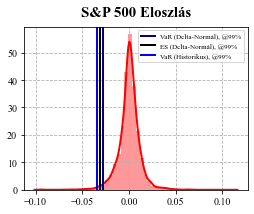

In [24]:
##Delta-normál
alfa=0.99
var_szorzo=(norm.ppf(alfa))*-1
var_delta_napi=np.abs(r_mean+r_std*var_szorzo)
es_delta_napi=np.abs(r_mean-r_std*(np.exp(-0.5*var_szorzo**2)/(((2*np.pi)**0.5*(1-alfa)))))
var_delta_10nap=var_delta_napi*np.sqrt(10)
es_delta_10nap=es_delta_napi*np.sqrt(10)
var_10_ertek=df["Close"][-1]*var_delta_10nap
es_10_ertek=df["Close"][-1]*es_delta_10nap
print(f"VaR@99% Delta-Normál {name_of_the_financial_instrument} @10nap: {var_10_ertek}")
print(f"ES@99% Delta-Normál {name_of_the_financial_instrument} @10nap: {es_10_ertek}")
##Historikus VaR
def quantile_exc(ser, q):
    ser_sorted = ser.sort_values()
    rank = q * (len(ser) + 1) - 1
    assert rank > 0, 'quantile is too small'
    rank_l = int(rank)
    return ser_sorted.iat[rank_l] + (ser_sorted.iat[rank_l + 1] - 
                                     ser_sorted.iat[rank_l]) * (rank - rank_l)
var_historikus_napi=np.abs(quantile_exc(df['Log_return'],1-alfa))
var_historikus_10nap=var_historikus_napi*np.sqrt(10)
var_historikus_ertek_10=df['Close'][-1]*var_historikus_10nap
print(f"VaR@99% Historikus {name_of_the_financial_instrument} @10nap: {var_historikus_ertek_10}")

#VaR ábrázoláshoz
var_line_abra=df
for i in range(1,len(df['Close'])):
	var_line_abra['var_vonal']=df['Close'][-1]-var_10_ertek
var_line_forecast=[]
for i in range(1,11):
	var_line_forecast.append(df['Close'][-1]-var_10_ertek)

##VaR ábra + Loghozam ábra
plt.rc('font', family='Times New Roman') #"serif"
fig= plt.figure(figsize=(4,3))
sns.distplot(df['Log_return'], norm_hist=True, bins=50, color='r', kde_kws=dict(linewidth=2))
plt.xlabel("")
plt.ylabel("")
plt.title(f"{name_of_the_financial_instrument} Eloszlás", fontsize=15, fontweight="bold", pad=10)
plt.axvline(x=var_delta_napi*-1, c="darkblue", label="VaR (Delta-Normál), @99%", linewidth=2)
plt.axvline(x=es_delta_napi*-1, c="black", label="ES (Delta-Normál), @99%", linewidth=2)
plt.axvline(x=var_historikus_napi*-1, c="blue", label="VaR (Historikus), @99%", linewidth=2)
plt.grid(True, linestyle="--")
plt.legend(loc="best", prop={'size': 7})
fig.savefig(f"plots\{name_of_the_financial_instrument}_var_hist.svg")
plt.show(block=False)
plt.close()

Következő 10 nap (Tényleges előrejelzési adatok) PROFIT/LOSS...

In [25]:
Profit_Loss["P/L"]=None
Profit_Loss["P/L"][0]=Profit_Loss["Plus_10_days"][0]-df['Close'][-1]
for i in range(9):
	Profit_Loss["P/L"][i+1]=Profit_Loss["Plus_10_days"][i+1]-Profit_Loss["Plus_10_days"][i]
print(Profit_Loss)
total_pl=Profit_Loss["P/L"].sum()
print(f" {name_of_the_financial_instrument} összes veszteség/nyereség a 10 nap alatt: {total_pl}")
##Előrejelzés intevalluma
while (True):
    try:
        n=input("Hány napra jelezzen előre a modell (alap eset n=10)")
        if n == "":
            n=10
        n=int(n)
        break
    except ValueError:
        "A megadott érték nem szám!"

last_date=index_col[-1]
last_date_next_day=last_date+datetime.timedelta(days=1)
fcast_dates=[]
for i in range(n):
	fcast_dates.append(last_date_next_day+datetime.timedelta(days=i))

index_col=pd.DataFrame(index_col, columns=['Date'])
index_col['date']=index_col['Date']
index_col.set_index('Date', inplace=True)

df['Abs_Log_return']=abs(df['Log_return'])
abs_r=abs(df['Log_return'])
abs_r=abs_r*100

            Plus_10_days     P/L
Date                            
2020-02-21       3337.75  -35.48
2020-02-24       3225.89 -111.86
2020-02-25       3128.21  -97.68
2020-02-26       3116.39  -11.82
2020-02-27       2978.76 -137.63
2020-02-28       2954.22  -24.54
2020-03-02       3090.23  136.01
2020-03-03       3003.37  -86.86
2020-03-04       3130.12  126.75
2020-03-05       3023.94 -106.18
 S&P 500 összes veszteség/nyereség a 10 nap alatt: -349.28999999999996


Naive Előrejelzés

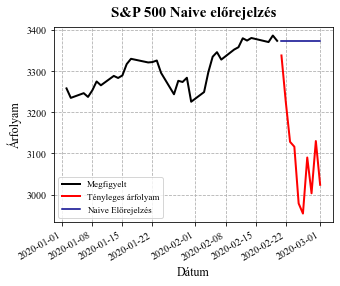

In [26]:
train_len_naive=len(df['Close'])
y_hat_naive=np.zeros(shape=(10,1))
for i in range(0,10):
	y_hat_naive[i]=df['Close'][train_len_naive-1]
#Plot
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(5,4))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges árfolyam", linewidth=2)
plt.plot(fcast_dates,y_hat_naive, label='Naive Előrejelzés', color="darkblue")
plt.title(f'{name_of_the_financial_instrument} Naive előrejelzés', fontsize=15, fontweight="bold", pad=10)
plt.legend(loc='lower left', prop={'size': 9})
plt.grid(True, linestyle='--')
plt.xlabel('Dátum', fontsize=12, labelpad=5)
plt.ylabel('Árfolyam', fontsize=12, labelpad=5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_naive.svg")
plt.show(block=False)
plt.close()

Monte Carlo Előrejelzés

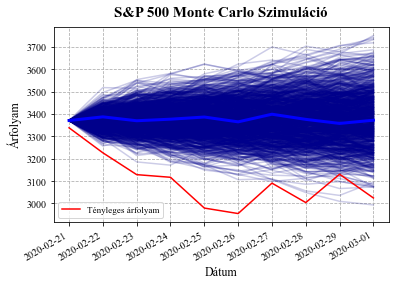

In [27]:
simulation_n=1000
simulation_dt=1/252
last_value=df['Close'][-1]
sim_values=np.zeros(shape=(n, simulation_n)) #n=10
loghozam_mc_0=(r_mean_ann-0.5*r_std_ann**2)*simulation_dt+r_std_ann*math.sqrt(simulation_dt)*norm.ppf(random.uniform(0, 1))
sim_values[0,:]=last_value*math.exp(loghozam_mc_0)
for i in range(1,simulation_n): #n=10
	for j in range(1,n):
		sim_values[j,i]=sim_values[j-1,i]*math.exp(((r_mean_ann-0.5*r_std_ann**2)*simulation_dt+r_std_ann*math.sqrt(simulation_dt)*norm.ppf(random.uniform(0, 1))))

##Legalsó-legfelső, középső trajektória
min_values_mc = []
max_values_mc = []
for i in range(1, 11):
    min_value_mc = min(sim_values[i-1,1:simulation_n])
    min_values_mc.append(min_value_mc)
    max_value_mc = max(sim_values[i-1,1:simulation_n])
    max_values_mc.append(max_value_mc)
mc_mid_pred=[]
pred_mc_temp = zip(max_values_mc,min_values_mc)
for list1_mc_i, list2_mc_i in pred_mc_temp:
    mc_mid_pred.append(list1_mc_i-list2_mc_i)
for i in range(1,11):
	mc_mid_pred[i-1]=(mc_mid_pred[i-1]/2)+min_values_mc[i-1]

##Plot Monte Carlo
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(6,4))
for i in range(1,simulation_n):
	plt.plot(fcast_dates,sim_values[:,i], color="darkblue", alpha=0.2)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges árfolyam")
plt.plot(fcast_dates, mc_mid_pred, linewidth=3, color="blue")
plt.xlabel('Dátum', fontsize=12, labelpad=5)
plt.ylabel('Árfolyam', fontsize=12, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} Monte Carlo Szimuláció', fontsize=15, fontweight="bold", pad=10)
plt.legend(loc='lower left', prop={'size': 9})
plt.grid(True, linestyle='--')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_mc.svg")
plt.show(block=False)
plt.close()

Árfolyam & hozam ábrázolás

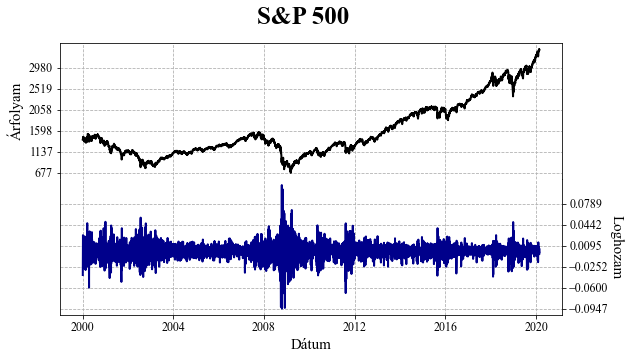

In [30]:
plt.rc('font', family='Times New Roman')
fig = plt.figure(figsize=(9,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle(f'{name_of_the_financial_instrument}', size=25, fontweight='bold')
axs[0].plot(index_col, df['Close'], color='black', linewidth=2)
axs[1].plot(index_col, df['Log_return'], color='darkblue', linewidth=2)
axs[1].yaxis.tick_right()
axs[0].set_ylabel('Árfolyam', fontsize=15, labelpad=5)
axs[1].set_xlabel('Dátum', fontsize=15)
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel('Loghozam', fontsize=15, rotation=270, labelpad=15)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_yticks(np.arange(min(df['Close']), max(df['Close']), (max(df['Close'])-min(df['Close']))*0.17))
axs[1].set_yticks(np.arange(min(df['Log_return']), max(df['Log_return']), (max(df['Log_return'])-min(df['Log_return']))*0.17))
axs[1].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].yaxis.grid(True, linestyle='--')
axs[0].xaxis.grid(True, linestyle='--')
axs[1].yaxis.grid(True, linestyle='--')
axs[1].xaxis.grid(True, linestyle='--')
plt.xticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arfolyam.svg")
plt.show(block=False)
plt.close()


Korrelogram

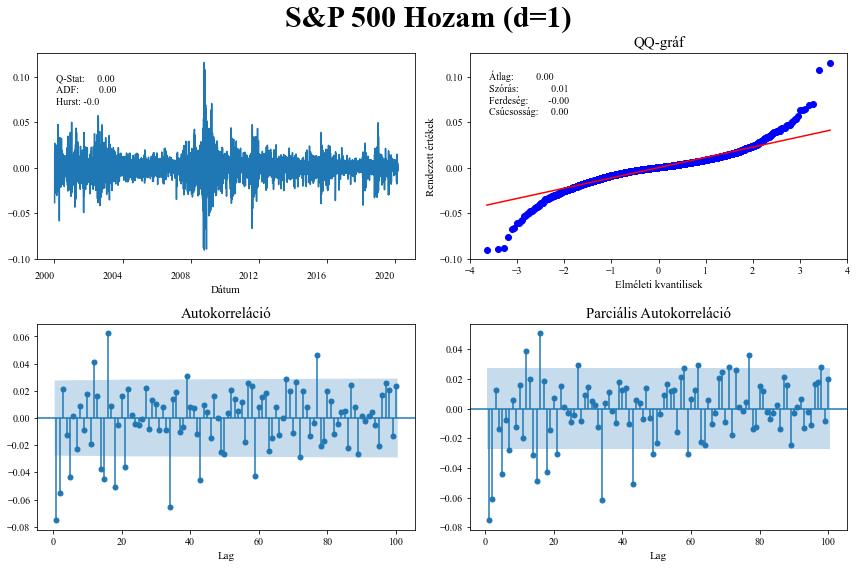

In [31]:
plot_correlogram(df['Eff_return'], lags=100, title=name_of_the_financial_instrument + ' Hozam (d=1)')
plt.show(block=False)
plt.close()

Tesztek

In [32]:
###############################Normalitás-teszt#################################
jarque_bera_test = stats.jarque_bera(df['Log_return'])
print('JB P-érték: {0:.16f}'.format(jarque_bera_test[1]))
print(f" JB Teszt-statisztika: {jarque_bera_test[0]}")

def chisquaretest(value,dof,confidency):
    critical = 1 - stats.chi2.cdf(JB, dof)
    if confidency >= critical:
        return ('Reject H0, P value= {0:.16f}'.format(critical))
    else:
        return ('Fail to reject H0, P value= {0:.16f}'.format(critical))
skew=df['Log_return'].skew()
kurt=df['Log_return'].kurtosis()
count=df['Log_return'].count()
JB=(count/6)*(skew**2+(1/4)*(kurt-3)**2)
print("Kurtosis:" , kurt)
print("Jarque–Bera:" , JB)
#the value of the JB is compared with chi square distribution to get the p value
print(chisquaretest(JB,2,0.05))

#Calculate Jarque–Bera (Pearson)
#Pearson-ból szokták számolni!
skew=df['Log_return'].dropna().skew()
kurt=stats.kurtosis(df['Log_return'].dropna(), fisher=False)
count=df['Log_return'].dropna().count()
JB=(count/6)*(skew**2+(1/4)*(kurt-3)**2)
print("Kurtosis:" , kurt)
print("Jarque–Bera:" , JB)
#the value of the JB is compared with chi square distribution to get the p value
print(chisquaretest(JB,2,0.05))

#normalitás_Teszt_shapiro
shapiro_wilk_test = stats.shapiro(df['Log_return'])
print(shapiro_wilk_test)
print('Shapiro_wilk P-érték: {0:.16f}'.format(shapiro_wilk_test[1]))
print(f"Shapiro-wilk Teszt statisztika: {shapiro_wilk_test[0]}")

#Kolmogorov–Smirnov test 
ks_test=stats.kstest(df['Log_return'], "norm")
print(ks_test)
# Student-féle t-eloszlás
print('{0:.16f}'.format(ks_test.pvalue))

##############################ADF-teszt#########################################
print("Dickey-Fuller teszt:")
dftest = adfuller(df['Log_return'].replace([np.inf, -np.inf,np.nan],0),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

JB P-érték: 0.0000000000000000
 JB Teszt-statisztika: 15891.11808780456
Kurtosis: 8.675743163302505
Jarque–Bera: 6842.324171125782
Reject H0, P value= 0.0000000000000000
Kurtosis: 11.665994833845266
Jarque–Bera: 15891.144838066362
Reject H0, P value= 0.0000000000000000
(0.909031093120575, 0.0)
Shapiro_wilk P-érték: 0.0000000000000000
Shapiro-wilk Teszt statisztika: 0.909031093120575
KstestResult(statistic=0.4792860118346922, pvalue=0.0)
0.0000000000000000
Dickey-Fuller teszt:
Test Statistic                -1.285550e+01
p-value                        5.242688e-24
#lags used                     3.300000e+01
number of observations used    5.030000e+03
critical value (1%)           -3.431651e+00
critical value (5%)           -2.862115e+00
critical value (10%)          -2.567076e+00
dtype: float64


ARIMA

    p  q           AIC           BIC
8   2  0 -30574.643138 -30548.524280
15  3  3 -30574.309684 -30522.071968
12  3  0 -30573.806628 -30541.158056
9   2  1 -30573.662630 -30541.014058
2   0  2 -30573.623370 -30547.504512
6   1  2 -30573.018437 -30540.369865
3   0  3 -30572.990399 -30540.341827
10  2  2 -30571.852401 -30532.674114
13  3  1 -30571.734809 -30532.556522
7   1  3 -30570.706287 -30531.528000
14  3  2 -30569.751711 -30524.043710
5   1  1 -30568.914501 -30542.795643
11  2  3 -30568.476431 -30522.768430
1   0  1 -30562.339473 -30542.750330
4   1  0 -30559.076306 -30539.487162
0   0  0 -30533.257060 -30520.197631
    p  q           AIC           BIC
8   2  0 -30574.643138 -30548.524280
2   0  2 -30573.623370 -30547.504512
5   1  1 -30568.914501 -30542.795643
1   0  1 -30562.339473 -30542.750330
12  3  0 -30573.806628 -30541.158056
9   2  1 -30573.662630 -30541.014058
6   1  2 -30573.018437 -30540.369865
3   0  3 -30572.990399 -30540.341827
4   1  0 -30559.076306 -30539.487162
1

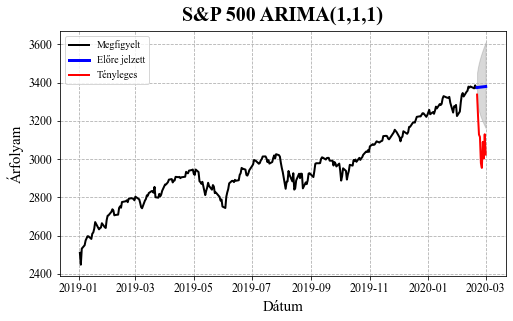

Ljung-Box Teszt: 
             lag_1    lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
P-values  0.942313  0.13062  0.051095  0.084506  0.003525  0.007351  0.006169   

             lag_8     lag_9    lag_10    lag_11    lag_12    lag_13  \
P-values  0.009554  0.015016  0.012694  0.013611  0.001098  0.001331   

            lag_14    lag_15        lag_16        lag_17        lag_18  \
P-values  0.000228  0.000016  3.379145e-08  6.118279e-08  1.207518e-09   

                lag_19        lag_20  
P-values  2.405286e-09  3.278945e-09  
Ljung-Box Teszt (sig. lagok): 
             lag_1    lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
P-values  0.942313  0.13062  0.051095  0.084506  0.003525  0.007351  0.006169   

             lag_8     lag_9    lag_10    lag_11    lag_12    lag_13  \
P-values  0.009554  0.015016  0.012694  0.013611  0.001098  0.001331   

            lag_14    lag_15        lag_16        lag_17        lag_18  \
P-values  0.000228  0.000016  3.37

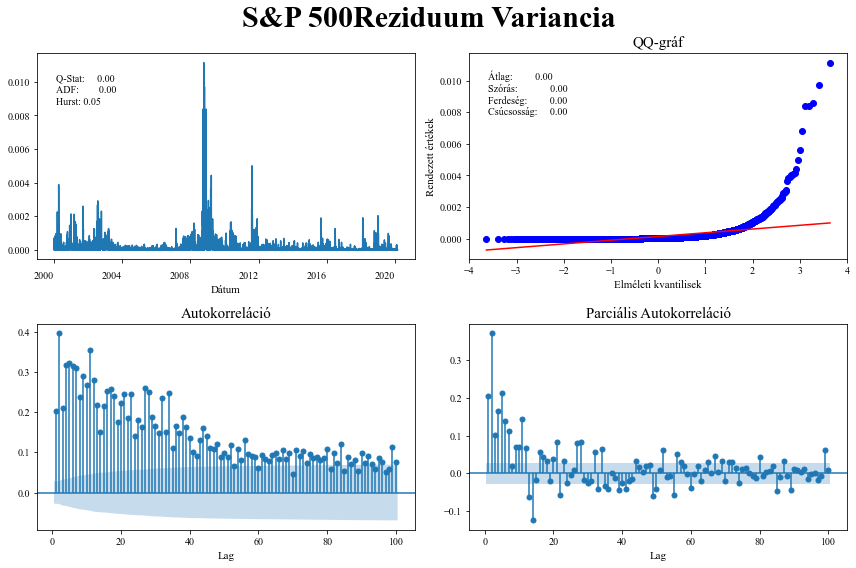

In [40]:
## opcio=["Log_Close", "Close"]
## while (True):
## 	log_or_normal=input('Írd be hogy záró (Close) vagy Log-záró (Log_Close) árfolyamot használjon (alap=Log_Close): ') or 'Log_Close'
## 	if log_or_normal in opcio:
## 		break
## 	else:
## 		continue
################LOG-os VERZIÓ###################
log_or_normal='Log_Close' ######################
################################################

order_aic_bic=[]
for p in range(4):
	for q in range(4):
		try:
			model=SARIMAX(df[log_or_normal],trend='c', order=(p,1,q))
			results=model.fit()
			order_aic_bic.append((p,q,results.aic, results.bic))
		except:
			order_aic_bic.append((p,q, None, None))
order_df=pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])
print(order_df.sort_values('AIC'))
print(order_df.sort_values('BIC'))

while (True):
	try:
		p_input=int(float(input('Adja meg az ARIMA(p,x,x) rendjét: ')))
		d_input=int(float(input(f'Adja meg az ARIMA({p_input},d,x) rendjét: ')))
		q_input=int(float(input(f'Adja meg az ARIMA({p_input},{d_input},q) rendjét: ')))
		break
	except ValueError:
		print("Egész számokat adjon meg a modell p és q rendjének, lehetőleg maximum 3-ig")
		continue

model=SARIMAX(df[log_or_normal],trend='c', order=(p_input,d_input,q_input))
results=model.fit()
print(results.summary())

forecast=results.get_forecast(steps=n)
if log_or_normal=='Close':
	mean_forecast=forecast.predicted_mean
	confidence_intervals=forecast.conf_int()
	lower_limits=confidence_intervals.loc[:,'lower Close']
	upper_limits=confidence_intervals.loc[:,'upper Close']
else:
	mean_forecast=np.exp(forecast.predicted_mean)
	confidence_intervals=np.exp(forecast.conf_int())
	lower_limits=confidence_intervals.loc[:,'lower Log_Close']
	upper_limits=confidence_intervals.loc[:,'upper Log_Close']


##ARIMA ábra
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2019':], df['Close'].loc['2019':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates, mean_forecast, color='blue', label='Előre jelzett', linewidth=3)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.fill_between(fcast_dates, lower_limits, upper_limits, color='grey', alpha=0.3)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Árfolyam', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARIMA({p_input},{d_input},{q_input})', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arima.svg")
plt.show(block=False)
plt.close()

resid_arima=results.resid
resid_arima=resid_arima[1:]
resid_arima_garch=100*resid_arima

##########################################Reziduum vizsgálat ARIMA#################################################
#Ljung Box
lb_test_arima=acorr_ljungbox(resid_arima, lags=20)
df_lb_test_arima = pd.DataFrame({'P-values': lb_test_arima[1]}).T
col_num_arima = df_lb_test_arima.shape[1]
col_names_arima = ['lag_'+str(num) for num in list(range(1,col_num_arima+1,1))]
df_lb_test_arima.columns = col_names_arima
print("Ljung-Box Teszt: ")
print(df_lb_test_arima)
##Szignifikáns Lag-ok
mask = df_lb_test_arima < 0.05
df_lb_test_arima[mask].dropna(axis=1)
print("Ljung-Box Teszt (sig. lagok): ")
print(df_lb_test_arima)
##KPSS
kpss_resid=sm.tsa.stattools.kpss(resid_arima, regression='ct')
print(f"KPSS Teszt statisztika: {kpss_resid[0]}")
print(f"KPSS p-érték: {kpss_resid[1]}")

#################Reziduum négyzet################################################################################
#Reziduum-négyzet vizsgálata ARCH hatás
#Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH)
het_test = het_arch(resid_arima)
print (f"ARCH teszt LM-Teszt statisztika:  {het_test[0]}")
print (f"ARCH teszt LM-Teszt p-érték:  {het_test[1]}")
print (f"ARCH teszt F-teszt statisztika:  {het_test[2]}")
print (f"ARCH teszt F-Teszt p-érték:  {het_test[3]}")
#Reziduum négyzet korrelogram
plot_correlogram(resid_arima.sub(resid_arima.mean()).pow(2), lags=100, title=name_of_the_financial_instrument +'Reziduum Variancia')
plt.show(block=False)
plt.close()


ARMA+GARCH

Egész számokat adjon meg a modell p és q rendjének, lehetőleg maximum 3-ig
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       Log_return_garch   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6842.57
Distribution:                  Normal   AIC:                           13693.1
Method:            Maximum Likelihood   BIC:                           13719.3
                                        No. Observations:                 5058
Date:                Wed, Mar 16 2022   Df Residuals:                     5057
Time:                        19:36:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------------------------------

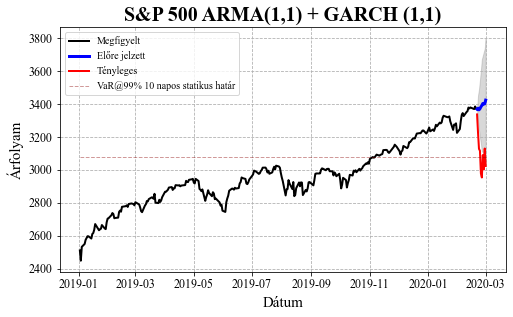

In [60]:
opcio_garch=["abs_r","Log_return_garch", "Eff_return_garch", "resid_arima_garch", "GARCH", "EGARCH","FIARCH","ARCH","HARCH", "normal", "t", "skewt","gaussian","studentst","skewstudent","ged","generalized error",  "AR", "constant","zero","LS","ARX","HAR","HARX", "", "0", "1"]
opcio_log_eff=["Log_return_garch", "Eff_return_garch"]
while (True):
	log_or_eff_or_arima=input('Hozamok (Log_return_garch)=ALAP vagy Abszolút Hozamok (abs_r) vagy ARIMA reziduum (resid_arima_garch): ') or 'Log_return_garch'
	if log_or_eff_or_arima in opcio_garch:
		pass
	else:
		continue	
	vol_type=input('Volatilitás típus("GARCH", "EGARCH"...) - (alap=GARCH): ') or 'GARCH'
	if vol_type in opcio_garch:
		pass
	else:
		continue
	dist_type=input('Eloszlás típus("normal", "t", "skewt"...) - (alap=t): ') or 'normal'
	if dist_type in opcio_garch:
		pass
	else:
		continue
	mean_type=input('Drift típus("AR","constant","ARX"...) - (alap=None): ') or ''
	if mean_type in opcio_garch:
		pass
	else:
		continue
	o_type=input('"O" értéke (lag - asszimetrikus komponens) - (alap=0, 1=GJR): ') or "0"
	if o_type in opcio_garch:
		o_type=int(float(o_type))
		break
	else:
		continue

##########################################################################

# if log_or_eff_or_arima in opcio_log_eff:
# 	if mean_type =='':
# 		gm=arch_model(df[log_or_eff_or_arima], p=1, q=1, o=o_type, vol=vol_type, dist=dist_type )
# 	else:
# 		gm=arch_model(df[log_or_eff_or_arima], p=1, q=1, o=o_type, vol=vol_type, dist=dist_type, mean=mean_type)
# elif log_or_eff_or_arima not in opcio_log_eff and log_or_eff_or_arima != "resid_arima_garch":
# 	if mean_type =='':
# 		gm=arch_model(abs_r, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type)
# 	else:
# 		gm=arch_model(abs_r, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type, mean=mean_type)
# else:
# 	if mean_type =='':
# 		gm=arch_model(resid_arima_garch, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type)
# 	else:
# 		gm=arch_model(resid_arima_garch, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type, mean=mean_type)


##Első fit, elemzés GARCH(1,1) - Legjobb átlalában
# gm_result=gm.fit(disp='off')
# print(gm_result.summary())

while (True):
	try:
		p_input_garch=int(float(input('Adja meg a végleges GARCH(p,x)-t: ')))
		q_input_garch=int(float(input(f"Adja meg a végleges GARCH({p_input_garch},q)-t: ")))
		o_input_garch=int(float(input(f'Adja meg a GARCH({p_input_garch},{q_input_garch}) O(lag) (GJR-GARCH) értékét: ')))
		break
	except ValueError:
		print("Egész számokat adjon meg a modell p és q rendjének, lehetőleg maximum 3-ig")
		continue
if log_or_eff_or_arima in opcio_log_eff:
	if mean_type =='':
		gm_rev=arch_model(df[log_or_eff_or_arima], p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type )
	else:
		gm_rev=arch_model(df[log_or_eff_or_arima], p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type, mean=mean_type)
elif log_or_eff_or_arima not in opcio_log_eff and log_or_eff_or_arima != "resid_arima_garch":
	if mean_type =='':
		gm_rev=arch_model(abs_r, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type)
	else:
		gm_rev=arch_model(abs_r, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type, mean=mean_type)
else:
	if mean_type =='':
		gm_rev=arch_model(resid_arima_garch, p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type)
	else:
		gm_rev=arch_model(resid_arima_garch, p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type, mean=mean_type)

gm_rev_result=gm_rev.fit(disp='off')
print(gm_rev_result.summary())

##KISZÁMÍTÁS
## Hozam=mu+phi1*hozam(t-1)+epsilon_t+theta1*epsilon(t-1)
## epsilon(t)=sigma(t)*z(t) #standard normális, vagy t
## sigma(t)^2=omega+alfa*epsilon(t-1)^2+beta*sigma(t-1)^2
##ARIMA-paraméter (ARIMA(1,1,1))
params_arima=results.params.index.values.tolist()
mu=results.params['intercept']
if 'ar.L1' in params_arima:
	phi1=results.params['ar.L1']
else:
	phi1=0
if 'ma.L1' in params_arima:
	theta1=results.params['ma.L1']
else:
	theta1=0
##GARCH-paraméter (1,1)
omega=gm_rev_result.params['omega']
alpha=gm_rev_result.params['alpha[1]']
beta=gm_rev_result.params['beta[1]']
print(mu, phi1,theta1, omega, alpha, beta)
sigma_t=np.sqrt(omega + alpha * (gm_rev_result.resid**2).shift(1) + beta*(gm_rev_result.conditional_volatility**2).shift(1)) ##GARCH 1,1 szórása
epsilon_t=sigma_t*np.random.standard_normal(len(sigma_t))
df['forecast_garch']=mu+phi1*df['Log_return_garch'].shift(1)+epsilon_t+theta1*epsilon_t.shift(1)


##VaR (Gyakorlatilag a legalsó trajektória, mert -2,3 körüli a véletlen normál tag)
df['var_garch']=(mu+sigma_t*((norm.ppf(0.99))*-1))
##########################

df=df.dropna()
index_col=df.index.values.tolist()
index_col=pd.to_datetime(index_col)
index_col=pd.DataFrame(index_col, columns=['Date'])
index_col['date']=index_col['Date']
index_col.set_index('Date', inplace=True)

abs_r=abs(df['Log_return']) #Újra kell mert törölt az adatsorból
abs_r=abs_r*100

##Basic ábra
#gm_rev_result.plot()
#plt.show(block=False)
# ##Illesztés, 252-napból 1 napos előrejelzés
## rolling_predictions = []
## test_size = 252  ##időszak végi 252-nap (minél nagyobb a szám annál jobb), teszt (rolling window -> veszi az elejétől a 252nap elejéig majd 1-el konstans növelgeti)
## for i in range(test_size):
## 	if log_or_eff_or_arima in opcio_log_eff:
## 		train=df[log_or_eff_or_arima][:-(test_size-i)]
## 	else:
## 		train=resid_arima_garch[:-(test_size-i)]
## 	if mean_type == '':
## 		model=arch_model(train, p=p_input_garch, q=q_input_garch, o=o_input_garch, vol = vol_type , dist = dist_type)
## 	else:
## 		model=arch_model(train, p=p_input_garch, q=q_input_garch, o=o_type, vol = vol_type , dist = dist_type, mean = mean_type)
## 	model_fit=model.fit(disp='off')
## 	pred = model_fit.forecast(horizon=1)
## 	rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
## rolling_predictions = pd.Series(rolling_predictions, index=index_col[-test_size:])
###Plot_rolling
## plt.figure(figsize=(10,4))
## if log_or_eff_or_arima in opcio_log_eff:
## 	true = plt.plot(index_col[-test_size:],df[log_or_eff_or_arima][-test_size:], color='deepskyblue', alpha=0.4, linewidth=2)
## else:
## 	true = plt.plot(index_col[-test_size:],resid_arima_garch[-test_size:], color='deepskyblue', alpha=0.4, linewidth=2)
## preds = plt.plot(rolling_predictions, color='red', linewidth=2)
## plt.title(f"{vol_type} ({p_input_garch},{q_input_garch}) Volatilitás - Mozgó előrejelzés (n=1)", fontsize=30, fontweight="bold")
## plt.legend(['Hozam (%)', 'Előre jelzett variancia (%)'], fontsize=15, loc='lower right')
## plt.grid(True, linestyle='--')
## plt.xticks(fontsize=15)
## plt.yticks(fontsize=15)
## plt.show(block=False)
## plt.close()

##n napos előrejelzés
while (True):
	#Ahhoz hogy n napos előrejelzés legyen loghozam kell, ezért nem lehet rolling forecasttal sztem
	log_or_eff_or_arima=input('Log vagy Effektív hozam alapján jelezzen előre (alap="Log")') or 'Log_return_garch'
	if log_or_eff_or_arima in opcio_garch:
		break
	else:
		continue	
if log_or_eff_or_arima in opcio_log_eff:
	train=df[log_or_eff_or_arima]
else:
	train=resid_arima_garch
if mean_type == '':
	model_f=arch_model(train, p=p_input_garch, q=q_input_garch, o=o_type, vol = vol_type , dist = dist_type)
else:
	model_f=arch_model(train, p=p_input_garch, q=q_input_garch, o=o_type, vol = vol_type , dist = dist_type, mean = mean_type)
model_f_fit = model_f.fit(disp='off')

##Bizonyítása az abszolút hozamnak - FASZSÁG
# plt.plot(gm_rev_result.conditional_volatility, color='grey')
# plt.plot(model_f_fit.conditional_volatility, color='red')
# plt.show(block=False)

##Előrejelzés
##JAVÍTANI KELLHET
pred = model_f_fit.forecast(horizon=n)
pred_std = np.sqrt((pred.variance.values[-1,:])/10000) #variancia 100*100 lesz
pred_std=list(pred_std)
pred_return=np.zeros(shape=(10))
pred_return[0]= mu+phi1*df['Log_return'][-1]+pred_std[0]*np.random.standard_normal(1)+theta1*pred_std[0]*np.random.standard_normal(1)

bound_n=1000
bounds=np.zeros(shape=(10,bound_n))
bounds[0,:]=df['Close'][-1]*math.exp(pred_return[0])

for j in range(1,bound_n):
	for i in range(1,10):
		pred_return[i]=mu+phi1*pred_return[i-1]+pred_std[i]*np.random.standard_normal(1)+theta1*pred_std[i-1]*np.random.standard_normal(1)
		bounds[i,j]=bounds[i-1,j]*math.exp(pred_return[i])

# plt.figure(figsize=(10,4))
# if log_or_eff_or_arima in opcio_log_eff:
# 	#plt.plot(index_col['date'].loc['2019':], df[log_or_eff_or_arima].loc['2019':] **2, label='Megfigyelt Variancia', color='grey', linewidth=2)
# 	plt.plot(index_col['date'].loc['2019':], abs_r.loc['2019':], label='Megfigyelt Volatilitás', color='grey', linewidth=2)
# else:
# 	#plt.plot(index_col['date'].loc['2019':], resid_arima_garch.loc['2019':] **2, label='Megfigyelt Variancia', color='grey', linewidth=2) #->Nem az igazi mivel 100 szorzod a varianciát így annak négyzete nem lesz kisebb hanem nagyobb lesz...
# 	plt.plot(index_col['date'].loc['2019':], abs_r.loc['2019':], label='Megfigyelt Volatilitás', color='grey', linewidth=2)
# plt.plot(fcast_dates, pred.variance.values[-1,:], color='red', label='Előre jelzett Volatilitás', linewidth=2)
# plt.xlabel('Dátum', fontsize=20, labelpad=10)
# plt.ylabel("Volatilitás (%)", fontsize=20, labelpad=10)
# plt.title(f"{tickerSymbol} {vol_type} ({p_input_garch},{q_input_garch})", fontsize=30, fontweight="bold")
# plt.legend()
# plt.grid(True, linestyle='--')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.show(block=False)
# plt.close()

max_values_ar_garch = []
min_values_ar_garch = []
for i in range(1, 11):
    min_value_ar_garch = min(bounds[i-1,1:bound_n])
    min_values_ar_garch.append(min_value_ar_garch)
    max_value_ar_garch = max(bounds[i-1,1:bound_n])
    max_values_ar_garch.append(max_value_ar_garch)
difference=[]
pred_transform_middle = zip(max_values_ar_garch,min_values_ar_garch)
for list1_i, list2_i in pred_transform_middle:
    difference.append(list1_i-list2_i)
for i in range(1,11):
	difference[i-1]=(difference[i-1]/2)+min_values_ar_garch[i-1]

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2019':], df['Close'].loc['2019':], label='Megfigyelt', color='black', linewidth=2)
plt.fill_between(fcast_dates,min_values_ar_garch, max_values_ar_garch, color='grey', alpha=0.3)
plt.plot(fcast_dates, difference, linewidth=3, color="blue", label="Előre jelzett")
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.plot(index_col['date'].loc['2019':],var_line_abra['var_vonal'].loc['2019':], linestyle='dashed', color="darkred", label="VaR@99% 10 napos statikus határ", alpha=0.4, linewidth=1)
plt.plot(fcast_dates,var_line_forecast, linestyle='dashed', color="darkred",alpha=0.4, linewidth=1)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} ARMA({p_input},{q_input}) + {vol_type} ({p_input_garch},{q_input_garch})", fontsize=20, fontweight="bold")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch.svg")
plt.show(block=False)
plt.close()

residuals_garch=model_f_fit.resid/100
vol_garch=model_f_fit.conditional_volatility/100
std_residuals_garch=residuals_garch/vol_garch


ARMA-GARCH Value at Risk ábra

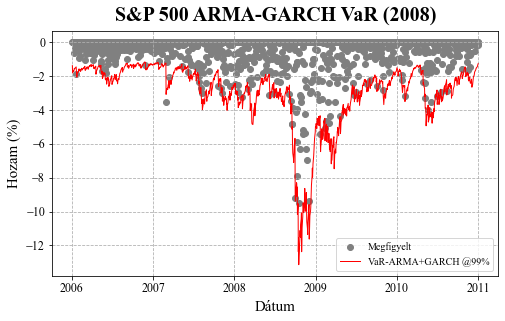

In [78]:
temp_scatter=df['Log_return_garch']
temp_scatter.loc[df['Log_return_garch'] >= 0]=0

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col['date'].loc['2006':'2010'],temp_scatter.loc['2006':'2010'], label='Megfigyelt', color='grey')
plt.plot(index_col['date'].loc['2006':'2010'],(np.abs(df['var_garch'].loc['2006':'2010'])*-1), linewidth=1, color="red", label="VaR-ARMA+GARCH @99%")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Hozam (%)', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARMA-GARCH VaR (2008)', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch_var.svg")
plt.show(block=False)
plt.close()

##Megj: Nem biztos hogy teljesen korrekt, forecastolni kéne és nem az illesztést nézni?

NEURÁLIS HÁLÓ IMPORT

In [77]:
import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperParameter as hp
from tensorflow.keras.callbacks import History
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import  StandardScaler

LSTM-RNN

In [ ]:
##SHAPE megformálása (NxD=1)
df1=abs_r
##Normalizálás - Nem a MinMaxScaler, mert az árfolyamnak nincs maximuma...
scaler=StandardScaler()
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
training_size=int(len(df1)*0.85) ##kb 0.85-t javasolja a szakirodalom
test_size=len(df1)-training_size
train_data, test_data=df1[0:training_size,:], df1[training_size:len(df1), :1]

##Dataset építés
##################
time_step= 100 ### MARAD!!!!!
##################
##Training set
X_train, y_train=create_dataset(train_data, time_step)
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
##Validation set
X_test, y_test= create_dataset(test_data, time_step)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

##Modell építés
number_of_epochs=20 #100 vagy 50
base_model_lstm = Sequential()
base_model_lstm.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(LSTM(units = 10, return_sequences = True))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(LSTM(units = 10, return_sequences = True))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(LSTM(units = 10))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(Dense(units = 1))
base_model_lstm.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error', metrics=['accuracy'])
base_model_lstm.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
base_model_lstm.fit(X_train, y_train,validation_data=(X_test,y_test), epochs = number_of_epochs, batch_size = 32, callbacks=[stop_early],verbose=2)
base_model_lstm.save(f'{name_of_the_financial_instrument}_my_model_base_lstm.h5')

##Modell értékelő funkció
def evaluate_model_lstm(model, X_test, y_test):
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    return display_df

results_nn_lstm = evaluate_model_lstm(base_model_lstm, X_test, y_test)
results_nn_lstm.index = ['Baseline']

##Hyper-paraméter tuning modell építése:
def build_model_lstm(hp):
    regressor = Sequential()
	#Input layer
    regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    # Number of hidden layers: 1 - 5
    # Number of Units: 10 - 50 with stepsize of 25
    for i in range(1, hp.Int("num_layers", 2, 6)):
        regressor.add(LSTM(units = hp.Int("units_" + str(i), min_value=10, max_value=50, step=10), return_sequences = True))
        # Tune dropout layer with values from 0 - 0.3.
        regressor.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    # Add output layer.
    regressor.add(LSTM(units = 10)) #Különben az output shape nem lesz jó
    regressor.add(Dense(units = 1))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    regressor.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'mean_squared_error', metrics=['accuracy'])
    
    return regressor

##Hyper-paraméter tuner indítása
tuner_lstm = kt.Hyperband(build_model_lstm,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=1,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     overwrite=True)
# Display search space summary
tuner_lstm.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_lstm.search(X_train, y_train,validation_data=(X_test,y_test), epochs=number_of_epochs, callbacks=[stop_early], verbose=2) #verbosa csak a kiírást állítja át
# Get the optimal hyperparameters from the results
best_hps=tuner_lstm.get_best_hyperparameters()[0]
h_model_lstm = tuner_lstm.hypermodel.build(best_hps)
h_model_lstm.summary()
# Train the hypertuned model
model_fit_lstm=h_model_lstm.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=number_of_epochs, callbacks=[stop_early], verbose=2)

##Modell Költség függvénye
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(4,3))
plt.plot(model_fit_lstm.history['loss'], label='loss', linewidth=2)
plt.plot(model_fit_lstm.history['val_loss'], label='validation_loss', linewidth=2)
plt.title("RNN-LSTM Loss Függvény", fontsize=20, fontweight="bold")
plt.legend(loc="best", prop={'size': 7})
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_loss_lstm.svg")
plt.show(block=False)
plt.close()

hyper_df_lstm = evaluate_model_lstm(h_model_lstm, X_test, y_test)
hyper_df_lstm.index = ["Hypertuned"]
results_nn_lstm.append(hyper_df_lstm)
print("Alap vs. Hyper_tuned modell (LSTM-RNN): ")
print(results_nn_lstm)

h_model_lstm.save(f'{name_of_the_financial_instrument}_my_model_hyper_lstm.h5')

In [ ]:
from tensorflow.python.keras.models import load_model
regressor = load_model(f'{name_of_the_financial_instrument}_my_model_hyper_lstm.h5')

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

#Illeszkedés ábra
##Jobb ábra
#Alap-plot, illeszkedésről
look_back=time_step #100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
##Reshape kell az ábrázoláshoz, hogy indexelni lehessen
trainPredictPlot=trainPredictPlot.reshape(-1)
testPredictPlot=testPredictPlot.reshape(-1)

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col, scaler.inverse_transform(df1), color="grey", linewidth=2, alpha=0.6)
plt.plot(index_col,trainPredictPlot,color="green", linewidth=2)
plt.plot(index_col,testPredictPlot, color="red", linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Abszolút Hozamok (%)', fontsize=15, labelpad=5)
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_lstm_fitted.svg")
plt.show(block=False)
plt.close()

##Előrejelzés (Utolsó 100-as szekvencia =time step, ebből előrejelez)
n_steps=time_step
test_data_len=(len(test_data)-n_steps) #visszamegy 100-at
x_input=test_data[test_data_len:].reshape(1,-1) #(1,100 shape)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
i=0 
while(i<n):
	if(len(temp_input)>n_steps):
		x_input=np.array(temp_input[1:])
		print("{} day input {}".format(i,x_input))
		x_input=x_input.reshape((1, n_steps, 1))
		yhat=regressor.predict(x_input, verbose=0)
		print("{} day output {}".format(i,yhat))
		temp_input.extend(yhat[0].tolist())
		temp_input=temp_input[1:]
		lst_output.extend(yhat.tolist())
		i=i+1
	else:
		x_input=x_input.reshape((1, n_steps,1))
		yhat= regressor.predict(x_input, verbose=0)
		temp_input.extend(yhat[0].tolist())
		lst_output.extend(yhat.tolist())
		i=i+1

day_new=np.arange(1,n_steps+1)
day_pred=np.arange(n_steps+1,n_steps+1+n)
len_df=len(df1)

lst_output_transformed=scaler.inverse_transform(lst_output)
lst_output_transformed=lst_output_transformed[:,0]
print(lst_output)

pred_org_nn_upper=[]
pred_org_nn_lower=[]
pred_org_nn_upper.append(df['Close'][-1] * math.exp(lst_output_transformed[0]/100))
pred_org_nn_lower.append(df['Close'][-1] * math.exp(-lst_output_transformed[0]/100))
for i in range(1,n):
	pred_org_nn_upper.append(pred_org_nn_upper[i-1]*math.exp(lst_output_transformed[i]/100))
	pred_org_nn_lower.append(pred_org_nn_lower[i-1]*math.exp(-lst_output_transformed[i]/100))

pred_org_nn_middle=[]
for i in range(n):
	pred_org_nn_middle.append((pred_org_nn_upper[i]+pred_org_nn_lower[i])/2)
pred_org_nn_lower=pd.Series(pred_org_nn_lower, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))
pred_org_nn_upper=pd.Series(pred_org_nn_upper, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))

fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2019':], df['Close'].loc['2019':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates, pred_org_nn_middle, color='blue', label='Előre jelzett', linewidth=2)
plt.fill_between(fcast_dates, pred_org_nn_lower, pred_org_nn_upper, color='grey', alpha=0.3)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.title(f"{name_of_the_financial_instrument} RNN-LSTM", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.legend(loc='upper left')
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_LSTM_pred.svg")
plt.show(block=False)
plt.close()

Neural-ARMA-Garch Model

In [ ]:
#df['forecast_garch']=abs(df['forecast_garch']) ## NEM BIZTOS HOGY ÁT KELL ALAKÍTANI NN-hez (SZTEM NEM KELL JOBB ANÉLKÜL)
#df2=df.iloc[:,6:8]
df2=df[["Abs_Log_return", "forecast_garch"]]
df2["Abs_Log_return"]=df2['Abs_Log_return']*100 #shape=(4210,2)

##Normalizálás - Nem a MinMaxScaler, mert az árfolyamnak nincs maximuma...
scaler=StandardScaler()
df2=scaler.fit_transform(np.array(df2).reshape(-1,2)) #shape(4210,2)
training_size1=int(len(df2)*0.85) ##próba:1 - eredetileg kb 0.85-t javasolja a szakirodalom
test_size1=len(df2)-training_size1
train_data1, test_data1=df2[0:training_size1,:], df2[training_size1:len(df2), :2] #shape (3578,2) és (632,2)

##Dataset építés
def create_dataset_2D(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a= dataset[i:(i+time_step),:]  ##FIX=:, nem 1
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return np.array(dataX), np.array(dataY)
##################
time_step= 100 ###  MARAD!!!!!!!!!!!!!!
##################
##Training set
X_train1, y_train1=create_dataset_2D(train_data1, time_step)
X_train1=X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 2)
##Validation set
X_test1, y_test1= create_dataset_2D(test_data1, time_step)
X_test1=X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 2)

##Modell építés
number_of_epochs1=20 #100 vagy 50
base_model = Sequential()
base_model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train1.shape[1], 2)))
base_model.add(Dropout(0.1))
base_model.add(LSTM(units = 10, return_sequences = True))
base_model.add(Dropout(0.1))
base_model.add(LSTM(units = 10, return_sequences = True))
base_model.add(Dropout(0.1))
base_model.add(LSTM(units = 10))
base_model.add(Dropout(0.1))
base_model.add(Dense(units = 1))
base_model.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error', metrics=['accuracy'])
base_model.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
base_model.fit(X_train1, y_train1,validation_data=(X_test1,y_test1), epochs = number_of_epochs1, batch_size = 32, callbacks=[stop_early],verbose=2)
base_model.save(f'{name_of_the_financial_instrument}_my_model_neural_ARMA_GARCH_base.h5')

def evaluate_model(model, X_test1, y_test1):
    eval_dict = model.evaluate(X_test1, y_test1, return_dict=True)
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    return display_df

results_nn = evaluate_model(base_model, X_test1, y_test1)
results_nn.index = ['Baseline']

def build_model(hp):
    regressor = Sequential()
	#Input layer:
    regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train1.shape[1], 2)))
    # Number of hidden layers: 1 - 5
    # Number of Units: 10 - 50 with stepsize of 25
    for i in range(1, hp.Int("num_layers", 2, 6)):
        regressor.add(LSTM(units = hp.Int("units_" + str(i), min_value=10, max_value=50, step=10), return_sequences = True))
        # Tune dropout layer with values from 0 - 0.3.
        regressor.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    # Add output layer:
    regressor.add(LSTM(units = 10)) #Különben az output shape nem lesz jó
    regressor.add(Dense(units = 1))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    regressor.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'mean_squared_error', metrics=['accuracy'])
    
    return regressor

tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=1,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     overwrite=True)
# Display search space summary
tuner.search_space_summary()

# This cell takes a long time to run when hyperband_iterations is large
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train1, y_train1,validation_data=(X_test1,y_test1), epochs=number_of_epochs1, callbacks=[stop_early], verbose=2) #verbosa csak a kiírást állítja át
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()
# Train the hypertuned model
model_fit1=h_model.fit(X_train1, y_train1,validation_data=(X_test1,y_test1), epochs=number_of_epochs1, callbacks=[stop_early], verbose=2)


plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(4,3))
plt.plot(model_fit1.history['loss'], label='loss', linewidth=2)
plt.plot(model_fit1.history['val_loss'], label='validation_loss', linewidth=2)
plt.title("Hibrid-RNN Loss Function", fontsize=20, fontweight="bold")
plt.legend(loc="best", prop={'size': 7})
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch_lstm_loss.svg")
plt.show(block=False)
plt.close()

hyper_df = evaluate_model(h_model, X_test1, y_test1)
hyper_df.index = ["Hypertuned"]
results_nn.append(hyper_df)
print(results_nn)

h_model.save(f'{name_of_the_financial_instrument}_my_model_ARMA_GARCH_hyper.h5')

In [ ]:
from tensorflow.python.keras.models import load_model
regressor1 = load_model(f'{name_of_the_financial_instrument}_my_model_ARMA_GARCH_hyper.h5')

train_predict1=regressor1.predict(X_train1) #shape(4209,1)
#create empty table with 2 fields
trainPredict_dataset_like1 = np.zeros(shape=(len(train_predict1), 2) )
# put the predicted values in the right field
trainPredict_dataset_like1[:,0] = train_predict1[:,0]
# inverse transform and then select the right field
train_predict1 = scaler.inverse_transform(trainPredict_dataset_like1)[:,0]
##########################################################################
test_predict1=regressor1.predict(X_test1)
#create empty table with 2 fields
testPredict_dataset_like1 = np.zeros(shape=(len(test_predict1), 2) )
# put the predicted values in the right field
testPredict_dataset_like1[:,0] = test_predict1[:,0]
# inverse transform and then select the right field
test_predict1 = scaler.inverse_transform(testPredict_dataset_like1)[:,0]
train_predict1=train_predict1.reshape(-1,1)
test_predict1=test_predict1.reshape(-1,1)

##Jobb ábra
#Alap-plot, illeszkedésről
look_back1=time_step #100
trainPredictPlot1=np.empty_like(df2[:,1])
trainPredictPlot1=trainPredictPlot1.reshape(-1,1)
trainPredictPlot1[:,:]=np.nan
testPredictPlot1=np.empty_like(df2[:,1])
testPredictPlot1=testPredictPlot1.reshape(-1,1)
testPredictPlot1[:,:]=np.nan
trainPredictPlot1[look_back1:len(train_predict1)+look_back1, :] = train_predict1
testPredictPlot1[len(train_predict1)+(look_back1*2)+1:len(df2)-1, :] = test_predict1
##Reshape kell az ábrázoláshoz, hogy indexelni lehessen
trainPredictPlot1=trainPredictPlot1.reshape(-1)
testPredictPlot1=testPredictPlot1.reshape(-1)
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col, abs_r.values, color="grey", linewidth=2, alpha=0.6) ##abs_r.values=scaler.inverse_transform(df1)
plt.plot(index_col,trainPredictPlot1,color="green", linewidth=2)
plt.plot(index_col,testPredictPlot1, color="red", linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('', fontsize=15, labelpad=5)
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch_lstm_fitted.svg")
plt.show(block=False)
plt.close()

##Előrejelzés Utolsó 100-as szekvenciát vesszük, és abból eltovla 1-et, majd megint egyet, jelezzük előre a 10 napot, ez így jó!!
n_steps1=time_step #100
test_data_len1=(len(test_data1)-n_steps1) #visszamegy 100-at
x_input1=test_data1[test_data_len1:]
x_input1= x_input1.reshape(2,-1) #(2,100)
temp_input1= x_input1

lst_output1=[]
i=0 
while(i<n):
	if(len(temp_input1[0])>n_steps1):
		x_input1= temp_input1[:,1:] #(2,100)
		x_input1=x_input1.reshape((1, n_steps1, 2))
		yhat1=regressor1.predict(x_input1, verbose=0) 
		tmp1=np.append(tmp1,yhat1[0]) 
		tmp2=np.append(tmp2,yhat1[0])
		tmp1=tmp1[1:]
		tmp2=tmp2[1:]
		temp_input1=np.vstack((tmp1,tmp2))
		lst_output1.extend(yhat1.tolist())
		i=i+1
	else:
		x_input1=x_input1.reshape((1, n_steps1,2))
		yhat1= regressor1.predict(x_input1, verbose=0)
		tmp1=np.append(temp_input1[0],yhat1[0])
		tmp2=np.append(temp_input1[1],yhat1[0])
		temp_input1=np.vstack((tmp1, tmp2)) #(2,101)=átugrik az if ágra
		lst_output1.extend(yhat1.tolist())
		i=i+1

day_new1=np.arange(1,n_steps1+1)
day_pred1=np.arange(n_steps1+1,n_steps1+1+n)
len_df1=len(df2) #len_df volt az eredi, len_df1

lst_output1=np.array(lst_output1)
lst_output_dataset_like1 = np.zeros(shape=(10, 2) )
lst_output_dataset_like1[:,0] = lst_output1[:,0]
lst_output_transformed1 = scaler.inverse_transform(lst_output_dataset_like1)[:,0]
#print(lst_output_transformed1)

pred_org_nn_upper1=[]
pred_org_nn_lower1=[]
pred_org_nn_upper1.append(df['Close'][-1] * math.exp(lst_output_transformed1[0]/100))
pred_org_nn_lower1.append(df['Close'][-1] * math.exp(-lst_output_transformed1[0]/100))
for i in range(1,n):
	pred_org_nn_upper1.append(pred_org_nn_upper1[i-1]*math.exp(lst_output_transformed1[i]/100))
	pred_org_nn_lower1.append(pred_org_nn_lower1[i-1]*math.exp(-lst_output_transformed1[i]/100))

pred_org_nn_middle1=[]
for i in range(n):
	pred_org_nn_middle1.append((pred_org_nn_upper1[i]+pred_org_nn_lower1[i])/2)
pred_org_nn_lower1=pd.Series(pred_org_nn_lower1, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))
pred_org_nn_upper1=pd.Series(pred_org_nn_upper1, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2019':], df['Close'].loc['2019':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates, pred_org_nn_middle1, color='blue', label='Előre jelzett', linewidth=2)
plt.fill_between(fcast_dates, pred_org_nn_lower1, pred_org_nn_upper1, color='grey', alpha=0.3)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.plot(index_col['date'].loc['2019':],var_line_abra['var_vonal'].loc['2019':], linestyle='dashed', color="darkred", label="VaR@99% 10 napos statikus határ", alpha=0.4, linewidth=1)
plt.plot(fcast_dates,var_line_forecast, linestyle='dashed', color="darkred",alpha=0.4, linewidth=1)
plt.title(f"{name_of_the_financial_instrument} Neurális-ARMA-GARCH Előrejelzés", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.grid(True, linestyle="--")
plt.legend(loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_ARMA_GARCH_LSTM_pred.svg")
plt.show(block=False)
plt.close()

NEURAL-ARMA-GARCH Value at Risk ábra

In [ ]:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col['date'].loc['2006':'2010'],temp_scatter.loc['2006':'2010'], label='Megfigyelt', color='grey')
plt.plot(index_col['date'].loc['2006':'2010'],trainPredictPlot1.loc['2006':'2010'],color="red", linewidth=1, label="VaR-LSTM+ARMA+GARCH")
plt.plot(index_col['date'].loc['2006':'2010'],testPredictPlot1.loc['2006':'2010'], color="red", linewidth=1)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Hozam (%)', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} NEURÁLIS-ARMA-GARCH VaR (2008)', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_neural_arma_garch_var.svg")
plt.show(block=False)
plt.close()

END-result plots

In [ ]:
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Árfolyam', color='black', linewidth=2)
plt.plot(fcast_dates, pred_org_nn_middle, color='darkblue', label='LSTM-RNN előrejelzés', linewidth=2)
plt.plot(fcast_dates, pred_org_nn_middle1, color='green', label='Neurális-ARMA-GARCH előrejelzés', linewidth=2)
plt.plot(fcast_dates, difference, color='darkviolet', label='ARMA-GARCH előrejelzés', linewidth=2)
#plt.plot(fcast_dates, mean_forecast, color='darkgreen', label='ARIMA előrejelzés', linewidth=2)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges árfolyam", linewidth=2)
plt.plot(index_col['date'].loc['2019':],var_line_abra['var_vonal'].loc['2019':], linestyle='dashed', color="darkred", label="VaR@99% 10 napos statikus határ", alpha=0.4, linewidth=1)
plt.plot(fcast_dates,var_line_forecast, linestyle='dashed', color="darkred",alpha=0.4, linewidth=1)
plt.title(f"{name_of_the_financial_instrument} Előrejelzések összehasonlítása", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--")
plt.legend(loc='upper left')
fig.savefig(f"plots\{name_of_the_financial_instrument}_osszes_elorejelzes.svg")
plt.show(block=False)
plt.close()

#####################################################################Output/Save-BACKUP################################################################################
# df.to_csv(tickerSymbol+'.csv')
# output_data_mid=pd.DataFrame(y_hat_naive,mc_mid_pred,mean_forecast, difference, pred_org_nn_middle, pred_org_nn_middle1, index=fcast_dates)
# output_data_mid.rename(columns={'y_hat_naive': 'Naive_mid', 'mc_mid_pred': 'Monte_Carlo_mid','mean_forecast': 'ARIMA_mid','difference': 'ARMA_GARCH_mid','pred_org_nn_middle': 'LSTM_RNN_mid','pred_org_nn_middle1': 'NEURAL_ARMA_GARCH_mid'}, inplace=True)
# output_data_mid.to_csv(f"{tickerSymbol}_mid_pred.csv")
# output_data_lower=pd.DataFrame(min_values_mc,lower_limits, min_values_ar_garch, pred_org_nn_lower, pred_org_nn_lower1, index=fcast_dates)
# output_data_lower.rename(columns={'min_values_mc': 'Monte_Carlo_lower','lower_limits': 'ARIMA_lower','min_values_ar_garch': 'ARMA_GARCH_lower','pred_org_nn_lower': 'LSTM_RNN_lower','pred_org_nn_lower1': 'NEURAL_ARMA_GARCH_lower'}, inplace=True)
# output_data_lower.to_csv(f"{tickerSymbol}_lower_pred.csv")


Előrejelzés pontossága

In [ ]:
##NAIVE
print("Naive: ")
evaluate(Profit_Loss["Plus_10_days"],y_hat_naive)
##Monte-Carlo
print("MC: ")
evaluate(Profit_Loss["Plus_10_days"],mc_mid_pred)
##ARIMA
print("ARIMA: ")
evaluate(Profit_Loss["Plus_10_days"], mean_forecast)
##ARMA-GARCH
print("ARMA+GARCH: ")
evaluate(Profit_Loss["Plus_10_days"], difference)
##LSTM
print("LSTM: ")
evaluate(Profit_Loss["Plus_10_days"], pred_org_nn_middle)
##Hybrid
print("LSTM+ARMA+GARCH: ")
evaluate(Profit_Loss["Plus_10_days"], pred_org_nn_middle1)